<a href="https://github.com/seki-shu/Group15_Multimodal/blob/Dreamer-V2_Pendulum/Dreamer_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

In [1]:
%pip install --upgrade gym
%pip install gym[classic_control]
%pip install numpy<2
%pip install imageio[ffmpeg]
%pip install torchvision
%pip install tensorboard

Note: you may need to restart the kernel to use updated packages.
  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [77 lines of output]
      
      
      WARNING, No "Setup" File Exists, Running "buildconfig/config.py"
      Using WINDOWS configuration...
      
      Making dir :prebuilt_downloads:
      Downloading... https://www.libsdl.org/release/SDL2-devel-2.0.16-VC.zip 13d952c333f3c2ebe9b7bc0075b4ad2f784e7584
      Unzipping :prebuilt_downloads\SDL2-devel-2.0.16-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_image/release/SDL2_image-devel-2.0.5-VC.zip 137f86474691f4e12e76e07d58d5920c8d844d5b
      Unzipping :prebuilt_downloads\SDL2_image-devel-2.0.5-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_ttf/release/SDL2_ttf-devel-2.0.15-VC.zip 1436df41ebc47ac36e02ec9bda5699e80ff9bd27
      Unzipping :prebuilt_downloads\SDL2_ttf-devel-2.0.15-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_mixer/release/SDL2_mixer-devel-2.0.4-VC.zi

Note: you may need to restart the kernel to use updated packages.


�w�肳�ꂽ�t�@�C����������܂���B


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import libraries

In [2]:
import gym
import matplotlib.pyplot as plt
import imageio
from typing import List

import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
import torch.distributions as td
from torch.distributions import Normal, Categorical, OneHotCategorical, OneHotCategoricalStraightThrough, Bernoulli
from torch.distributions.kl import kl_divergence
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils import clip_grad_norm_

import numpy as np

import os
import datetime
import time
import random
from IPython.display import Video, display

from PIL import Image

torch.cuda.empty_cache()

## Check device

In [3]:
# torch.deviceを定義．この変数は後々モデルやデータをGPUに転送する時にも使います
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## TrainedModels

In [4]:
class TrainedModels:
    def __init__(self, *models):
        """
        コンストラクタ.
        使用例: trained_models = TrainedModels(encoder, rssm, critic, actor)

        Params:
        -------
            models : nn.Module
                保存するモデル. 複数選択可.
        """
        assert np.all([nn.Module in model.__class__.__bases__ for model in models]), "models must be nn.Module"
        self.models = models

    def save(self, dir: str):
        """
        モデルを保存するメソッド.
        コンストラクタで渡したモデルをすべて保存する.

        Params:
        -------
            dir : str
                保存先ディレクトリ.
        """
        for model in self.models:
            torch.save(
                model.state_dict(),
                os.path.join(dir, f"{model.__class__.__name__}.pt")
            )

    def load(self, dir: str, device: str):
        """
        モデルを読み込むメソッド.
        ※モデルの名前とファイルの名前は同じにする.

        Params:
        -------
            dir : str
                読み込むディレクトリ.
            device : str
                読み込むデバイス. 'cpu', 'cuda'
        """
        for model in self.models:
            model.load_state_dict(
                torch.load(
                    os.path.join(dir, f"{model.__class__.__name__}.pt"),
                    map_location=device
                )
            )

## set_seed

In [5]:
def set_seed(seed: int):
    """
    Pytorchとnumpyのseed値を固定する.

    Params:
    -------
        seed : int
          シード値.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# モデルの実装


## RSSM

In [6]:
class RSSM(nn.Module):
    """
    RSSMのクラス.

    Methods:
    --------
        recurrent: 決定的状態hをrnnで得る.
        get_prior: 確率的状態zの事前分布を得る.
        get_posterior: 確率的状態zの事後分布を得る.
    """
    def __init__(self, mlp_hidden_dim: int, h_dim: int, z_dim: int, a_dim: int, n_classes: int, embedding_dim: int):
        """
        コンストラクタ.

        Params:
        --------
            mlp_hidden_dim : int
               mlpに通した後の次元数.
            h_dim : int
               決定的状態hの次元数.
            z_dim : int
               確率的状態zの次元数.
            a_dim : int
               行動の次元数.
            n_classes : int
               確率的状態zのカテゴリ数.
            embedding_dim : int
               観測画像の埋め込み次元数.
        """
        super().__init__()

        self.h_dim = h_dim
        self.z_dim = z_dim
        self.a_dim = a_dim
        self.n_classes = n_classes

        # Recurrent model
        # h_t = f(h_t-1, z_t-1, a_t-1)
        self.z_a_hidden = nn.Linear(z_dim * n_classes + a_dim, mlp_hidden_dim)
        self.rnn = nn.GRUCell(mlp_hidden_dim, h_dim)

        # Prior prediction
        # z_t+1_hat = f(h_t+1)
        self.prior_hidden = nn.Linear(h_dim, mlp_hidden_dim)
        self.prior_logits = nn.Linear(mlp_hidden_dim, z_dim * n_classes)

        # Posterior
        # z_t+1 = f(h_t+1, o_t+1)
        self.posterior_hidden = nn.Linear(h_dim + embedding_dim, mlp_hidden_dim)
        self.posterior_logits = nn.Linear(mlp_hidden_dim, z_dim * n_classes)

    def recurrent(self, h_prev: torch.Tensor, z_prev: torch.Tensor, a_prev: torch.Tensor):
        """
        決定的状態の状態遷移を求めるメソッド. RNNとしてGRUを使用する.
        h_t+1 = f(h_t, z_t, a_t)

        Params:
        -------
            h_prev : torch.Tensor (batch size, h_dim)
                現在時刻の決定的状態h_t
            z_prev : torch.Tensor (batch size, z_dim)
                現在時刻の確率的状態z_t
            a_prev : torch.Tensor (batch size, a_dim)
                現在時刻のアクションa_t

        Returns:
        -------
            h : torch.Tensor (batch size, h_dim)
                次時刻の決定的状態h_t+1
        """
        mlp_hidden = F.elu(self.z_a_hidden(torch.cat([z_prev, a_prev], dim=1)))
        h = self.rnn(mlp_hidden, h_prev)
        return h

    def get_prior(self,h: torch.Tensor, detach = False):
        """
        確率的状態zの事前分布を求めるメソッド.
        z_t+1_hat ~ p(h_t+1)

        Params:
            h : torch.Tensor (batch size, h_dim)
                次時刻の決定的状態h_t+1.
            detach : bool
                Trueの場合、detachする.

        ---------
        Returns:
            prior : torch.distributions.Distribution
                事前分布を求めるためのカテゴリカル分布.
            detached_prior : torch.distributions.Independent
                detachされた事前分布を求めるためのカテゴリカル分布.
        """
        mlp_hidden = F.elu(self.prior_hidden(h))
        logits = self.prior_logits(mlp_hidden) # (B, z_dim * n_classes,)
        logits = logits.reshape(logits.shape[0], self.z_dim, self.n_classes) # (B, z_dim, n_classes)

        prior = td.Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detached_prior = td.Independent(OneHotCategoricalStraightThrough(logits=logits.detach()), 1)
            return prior, detached_prior
        return prior

    def get_posterior(self, h: torch.Tensor, embedded_obs: torch.Tensor, detach = False):
        """
        確率的状態zの事後分布を求めるメソッド.
        z_t+1 ~ p(h_t+1, o_t+1)

        Params:
        -------
            h : torch.Tensor (batch size, h_dim)
                次時刻の決定的状態h_t+1.
            embedded_obs : torch.Tensor (batch size, embedding_dim)
                次時刻の画像の埋め込み
            detach : bool
                Trueの場合、detachする.

        Returns:
        --------
            posterior : torch.distributions.Distribution
                事後分布を求めるためのカテゴリカル分布.
            detached_posterior : torch.distributions.Independent
                detachされた事後分布を求めるためのカテゴリカル分布.
        """
        mlp_hidden = F.elu(self.posterior_hidden(torch.cat([h, embedded_obs], dim=1)))
        logits = self.posterior_logits(mlp_hidden) # (B, z_dim * n_classes)
        logits = logits.reshape(logits.shape[0], self.z_dim, self.n_classes) # (B, z_dim, n_classes)

        posterior = td.Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detached_posterior = td.Independent(OneHotCategoricalStraightThrough(logits=logits.detach()), 1)
            return posterior, detached_posterior
        return posterior

## Encoder

In [7]:
class Encoder(nn.Module):
    """
    ※画像(1, 64, 64)をエンコードする.
    画像はカラーじゃなくてグレースケールにするのでチャネル数が1.

    Methods:
    -------
        forward: 観測画像を埋め込む.
    """
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 48, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(48, 96, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(96, 192, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(192, 384, kernel_size=4, stride=2)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行うメソッド．観測画像をベクトルに埋め込む．
        (1, 64, 64) -> (1536, ) にエンコード.

        Params:
        -------
            obs : torch.Tensor (batch size, 1, 64, 64)
                環境から得られた観測画像．

        Returns:
        -------
            embed : torch.Tensor (batch size, 1536)
                観測を1024次元のベクトルに埋め込んだもの．
        """
        embed = F.elu(self.conv1(obs))
        embed = F.elu(self.conv2(embed))
        embed = F.elu(self.conv3(embed))
        embed = self.conv4(embed).reshape(embed.shape[0], -1)
        return embed

## Decoder

In [8]:
class Decoder(nn.Module):
    """
    内部状態表現h, zから画像(1, 64, 64)を再構成する.
    ただし画像は平均を計算して、その平均で分散１の正規分布から得る.

    Methods:
        forward: 画像の再構成を行う.
    """
    def __init__(self, h_dim: int, z_dim: int, n_classes: int):
        """
        コンストラクタ．

        Params:
        --------
            h_dim : int
                決定的状態hの次元数．
            z_dim : int
                確率的状態zの次元数．
            n_classes : int
                確率的状態zのカテゴリ数．
        """
        super().__init__()
        self.fc = nn.Linear(h_dim + z_dim * n_classes, 1536)
        self.deconv1 = nn.ConvTranspose2d(1536, 192, kernel_size=5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(192, 96, kernel_size=5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(96, 48, kernel_size=6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(48, 1, kernel_size=6, stride=2)

    def forward(self, h: torch.Tensor, z: torch.Tensor):
        """
        順伝播を行うメソッド．内部状態h, zから画像を再構成する．
        mean = f(h_t, z_t)
        o_t = N(mean, 1)

        Params:
        --------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z

        Returns:
        -------
            obs_dist : torch.distributions.Independent
                再構成された画像を得るための多変量正規分布．
        """
        x = self.fc(torch.cat([h, z], dim=1))
        x = x.reshape(x.shape[0], 1536, 1, 1)
        x = F.elu(self.deconv1(x))
        x = F.elu(self.deconv2(x))
        x = F.elu(self.deconv3(x))
        mean = self.deconv4(x)
        obs_dist = td.Independent(Normal(mean, 1), 3)
        return obs_dist


## Reward Model

In [9]:
class RewardModel(nn.Module):
    """
    報酬予測モデル.
    ただし報酬は平均を計算して、その平均で分散が1の正規分布から得る.

    Methods:
    -------
        forward: 報酬予測を行う.
    """
    def __init__(self, h_dim: int, z_dim: int, n_classes: int, hidden_dim: int):
        """
        コンストラクタ.

        Params:
        -------
            h_dim : int
                決定的状態hの次元数.
            z_dim : int
                確率的状態zの次元数.
            n_classes : int
                確率的状態zのカテゴリ数.
            hidden_dim : int
                MLPを通した後のユニット数.

        """
        super().__init__()
        self.fc1 = nn.Linear(h_dim + z_dim * n_classes, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, h: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        報酬予測を行うメソッド.
        mean = f(h_t, z_t)
        r_t = N(mean, 1)

        Params:
        ----------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z

        Returns:
        -------
            reward_dist : torch.distributions.Independent
                報酬予測をするための多変量正規分布.
        """
        x = F.elu(self.fc1(torch.cat([h, z], dim=1)))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        mean = self.fc4(x)
        reward_dist = td.Independent(Normal(mean, 1), 1)
        return reward_dist

## Discount Model


In [10]:
class DiscountModel(nn.Module):
    """
    現在のエピソードが終端かどうかを求めるモデル.

    Methods:
    --------
        forward: 終端かどうか予測を行う.
    """
    def __init__(self, h_dim: int, z_dim: int, n_classes: int, hidden_dim: int):
        """
        コンストラクタ.

        Params:
        -------
            h_dim : int
                決定的状態hの次元数.
            z_dim : int
                確率的状態zの次元数.
            n_classes : int
                確率的状態zのカテゴリ数.
            hidden_dim : int
                MLPを通した後のユニット数.
        """
        super().__init__()
        self.fc1 = nn.Linear(h_dim + z_dim * n_classes, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, h: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        現在のエピソードが終端かどうか求める.
        p = f(h_t, z_t)
        gamma_t = Bernoulli(p)

        Params:
        -------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z

        Returns:
        -------
            discount_dist : torch.distributions.Independent
                終端かどうか予測を行うベルヌーイ分布
        """
        x = F.elu(self.fc1(torch.cat([h, z], dim=1)))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        p_logits = self.fc4(x)
        discount_dist = td.Independent(Bernoulli(logits=p_logits), 1)
        return discount_dist

## Actor

In [11]:
class Actor(nn.Module):
    """
    最適行動を出力するモデル.
    今回はAtariではないので連続な行動を出力する.

    Methods:
    -------
        forward: 最適行動を出力する.
    """
    def __init__(self, action_dim: int, h_dim: int, z_dim: int, n_classes: int, hidden_dim: int):
        """
        コンストラクタ.

        Params:
        -------
            action_dim : int
                行動の次元数.
            h_dim : int
                決定的状態hの次元数.
            z_dim : int
                確率的状態zの次元数.
            n_classes : int
                確率的状態zのカテゴリ数.
            hidden_dim : int
                MLPを通した後のユニット数.
        """
        super().__init__()
        self.fc1 = nn.Linear(h_dim + z_dim * n_classes, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, action_dim)
        self.fc_std = nn.Linear(hidden_dim, action_dim)

    def forward(self, h: torch.Tensor, z: torch.Tensor, eval: bool):
        """
        最適行動を出力する.
        a_t = f(h_t, z_t)

        Params:
        -------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h.
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z.
            eval : bool
                評価モードかどうか.

        Returns:
        -------
            actions : torch.Tensor (batch size, action_dim)
                最適行動.
            action_log_probs : torch.Tensor (batch size, 1)
                最適行動の対数尤度.
            action_entropy : torch.Tensor (batch size, 1)
                最適行動のエントロピー.
        """
        x = F.elu(self.fc1(torch.cat([h, z], dim=1)))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        mean = self.fc_mean(x) # (batch_size, action_dim)
        std = F.softplus(self.fc_std(x)) # (batch_size, action_dim)

        if eval:
            actions = torch.tanh(mean) # action spaceを(-1, 1)にしてる. 環境によっては変更必要かも.
            return actions, None, None

        # Dreamer V2の連続空間でのActorがどうなっているかいまいち分からなかったので、とりあえず以下のように実装しました。
        # まずactionを正規分布からサンプルした後、tanh関数に通して(-1, 1)にします。
        # 対数尤度を求めるときに、log p(actions) = log (Normal(unscaled_actions) * |det(∂unscaled_actions / ∂actions)|)(https://arxiv.org/pdf/1801.01290 Appendix C)となります
        # tanhの微分は1-tanh^2で、正規分布の分散共分散行列は対角行列なので、ヤコビアンはdiag(1 - tanh^2)となります。
        # 間違ってるかもしれません...
        action_dist = td.Independent(Normal(mean, std), 1)
        unscaled_actions = action_dist.rsample()
        actions = torch.tanh(unscaled_actions)
        # ここの実装がわかりません．．以下のコードに修正したら形は合っていて，動きはします．
        action_log_probs = (action_dist.log_prob(unscaled_actions) - torch.log(1 - actions.pow(2) + 1e-7)).sum(dim=1, keepdim=True)
        # action_log_probs = action_dist.log_prob(unscaled_actions).unsqueeze(-1) - torch.log(1 - actions.pow(2) + 1e-7).sum(dim=1, keepdim=True)
        action_entropy = action_dist.entropy()
        return actions, action_log_probs, action_entropy

## Critic

In [12]:
class Critic(nn.Module):
    """
    状態価値を出力するモデル.

    Methods:
    --------
        forward: 状態価値を出力する.
    """
    def __init__(self, h_dim: int, z_dim: int, n_classes: int, hidden_dim: int):
        """
        コンストラクタ.

        params:
        -------
            h_dim : int
                決定的状態hの次元数.
            z_dim : int
                確率的状態zの次元数.
            n_classes : int
                確率的状態zのカテゴリ数.
            hidden_dim : int
                MLPを通した後のユニット数.
        """
        super().__init__()
        self.fc1 = nn.Linear(h_dim + z_dim * n_classes, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, h: torch.Tensor, z: torch.Tensor):
        """
        状態価値を出力する.
        v_t = f(h_t, z_t)

        Params:
        -------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h.
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z.

        Return:
        -------
            values : torch.Tensor (batch size, 1)
                状態価値.
        """
        x = F.elu(self.fc1(torch.cat([h, z], dim=1)))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        values = self.out(x)
        return values

# その他機能

## Config

In [13]:
class Config:
    def __init__(self, **kwargs):
        # camera settings
        self.camera_heights=64 # image height
        self.camera_widths=64 # image width
        
        # data settings
        self.buffer_size = 100_000
        self.batch_size = 50
        self.seq_length = 50
        self.imagination_horizon = 15

        # model dimensions
        self.z_dim = 32
        self.n_classes = 32
        self.h_dim = 600
        self.mlp_hidden_dim = 400
        self.embedding_dim = 1536
        

        # learning parameters
        self.model_lr = 2e-4 # world model(transition / prior / posterior / discount / image predictor)の学習率
        self.actor_lr = 4e-5
        self.critic_lr = 1e-4
        self.epsilon = 1e-5 # optimizerのεの値
        self.weight_decay = 1e-6
        self.gradient_clipping = 100
        self.kl_loss_scale = 0.1
        self.kl_balance = 0.8
        self.actor_entropy_scale = 1e-4 # 連続値制御の場合 Atariの場合は1e-3
        self.slow_critic_update = 100
        self.reward_loss_scale = 1.0
        self.discount_loss_scale = 1.0
        self.update_freq = 4

        # lambda return params
        self.discount = 0.995 # 割引率
        self.lambda_ = 0.95

        # learning period settings
        self.NUM_ITER = 10_000
        self.seed_iter = 5_000 # 事前にランダム行動で探索する回数
        self.eval_freq = 1e3
        self.eval_episodes = 5

cfg = Config()

## Replay Buffer


In [14]:
class ReplayBuffer:
    """
    リプレイバッファ.
    """
    def __init__(self, capacity: int, obs_shape: tuple[int], action_dim: int):
        """
        コンストラクタ.

        Params:
        -------
            capacity : int
                バッファの最大容量.
            obs_shape : tuple[int]
                観測の形状.
            action_dim : int
                行動の次元数.
        """
        self.capacity = capacity
        self.obs_shape = obs_shape
        self.action_dim = action_dim

        self.observations = np.zeros((capacity, *obs_shape), dtype=np.float32)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.rewards = np.zeros((capacity, 1), dtype=np.float32)
        self.dones = np.zeros((capacity, 1), dtype=bool)
        self.index = 0
        self.is_filled = False

    def push(self, observation: np.ndarray, action: np.ndarray, reward: float, done: bool):
        """
        バッファに追加する.

        Params:
        -------
            observation : np.ndarray (obs_shape)
                観測.
            action : np.ndarray (action_dim)
                行動.
            reward : float
                報酬.
            done : bool
                エピソードの終了.
        """
        self.observations[self.index] = observation
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.dones[self.index] = done

        if self.index == self.capacity - 1:
            self.is_filled = True
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size: int, chunk_length: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        バッファからサンプリングする.

        Params:
        -------
            batch_size : int
                サンプリングするデータの数.

            chunk_length : int
                chunkの長さ

        Returns:
        --------
            sampled_observations : np.ndarray (B, T, 1, 64, 64)
                サンプリングされた観測.
            sampled_actions : np.ndarray (B, T, action_dim)
                サンプリングされた行動.
            sampled_rewards : np.ndarray (B, T, 1)
                サンプリングされた報酬.
            sampled_dones : np.ndarray (B, T, 1)
                サンプリングされたエピソードの終了判定.
        """
        episode_borders = np.where(self.dones)[0] # episodeが終了するindex
        sampled_indices = []
        for _ in range(batch_size):
            crossed_border = True # borderを跨いだかどうか
            while crossed_border:
                initial_idx = np.random.randint(self.capacity - chunk_length + 1)
                final_idx = initial_idx + chunk_length - 1
                crossed_border = np.logical_and(initial_idx <= episode_borders,
                                                episode_borders < final_idx).any()
            sampled_indices += list(range(initial_idx, final_idx + 1)) # 最終的に(batch_size * chunk_length)

        sampled_observations = self.observations[sampled_indices].reshape(
            batch_size, chunk_length, *self.obs_shape)
        sampled_actions = self.actions[sampled_indices].reshape(
            batch_size, chunk_length, self.action_dim)
        sampled_rewards = self.rewards[sampled_indices].reshape(
            batch_size, chunk_length, 1)
        sampled_dones = self.dones[sampled_indices].reshape(
            batch_size, chunk_length, 1)
        return sampled_observations, sampled_actions, sampled_rewards, sampled_dones

    def save(self, dir: str):
        np.save(f"{dir}/observations.npy", self.observations)
        np.save(f"{dir}/actions.npy", self.actions)
        np.save(f"{dir}/rewards.npy", self.rewards)
        np.save(f"{dir}/dones.npy", self.dones)

    def load(self, dir: str):
        self.observations = np.load(f"{dir}/observations.npy")
        self.actions = np.load(f"{dir}/actions.npy")
        self.rewards = np.load(f"{dir}/rewards.npy")
        self.dones = np.load(f"{dir}/dones.npy")


## calculate λ-target  
元論文ではλ: 0.95, H=15  
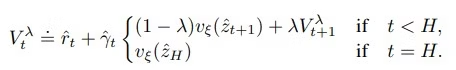

In [15]:
def calculate_lambda_target(rewards: torch.Tensor, discounts: torch.Tensor, values: torch.Tensor, lambda_: float):
    """
    λ-targetを計算する.

    Params:
    -------
        rewards : torch.Tensor (imagination_horizon, D)
            報酬. 1次元目が時刻tを表しており、2次元目は自由な変数で、想像の軌道を作成するとき入力されるindex.
        discounts : torch.Tensor (imagination_horizon, D)
            割引率.
        values : torch.Tensor (imagination_horizon, D)
            状態価値.
        lambda_ : float
            λ. 元論文ではλ=0.95

    Returns:
    -------
        V_lambda : torch.Tensor (imagination_horizon, D)
            lambda_targetの値.
    """
    V_lambda = torch.zeros_like(rewards)

    for t in reversed(range(rewards.shape[0])):
        if t == rewards.shape[0] - 1: # t = H(下の条件式)
            V_lambda[t] = rewards[t] + discounts[t] * values[t]
        else:
            V_lambda[t] = rewards[t] + discounts[t] * ((1 - lambda_) * values[t+1] + lambda_ * V_lambda[t+1])

    return V_lambda

## Preprocess obs

In [16]:
def preprocess_obs(obs):
    """
    画像の変換. [0, 255] -> [0, 1]
    画像をグレースケールに変換
    """
    # トリミング
    frame = obs[125:375, 125:375]
    height, width = cfg.camera_widths, cfg.camera_heights
    frame = Image.fromarray(frame) # PILで画像を開く
    frame = frame.resize((cfg.camera_widths, cfg.camera_heights), Image.Resampling.LANCZOS) # リサイズ
    frame = frame.convert("L") # grayscaleにしてる
    frame = np.array(frame).reshape(height, width, 1)
    frame = frame.astype(np.float32) / 255.0 - 0.5
    return frame

## frames_show

In [17]:
def frames_show(frames):
    # ファイル名を生成
    now = datetime.datetime.now()
    save_dir = "./video"
    file_name = now.strftime("Pendulum_%m%d_%H%M%S.mp4")
    file_path = os.path.join(save_dir, file_name)  # 保存先を指定
    # 動画生成
    with imageio.get_writer(file_path, fps=30) as writer:
        for frame in frames:
            writer.append_data(frame)
    
    print(f"動画の保存が完了しました: {file_name}")

## Agent

In [18]:
class Agent:
    """
    Agentのクラス.

    Methods:
    --------
        __call__: Agentが一連の流れを行う.
        reset: 決定的状態hのリセット.
    """
    def __init__(self, encoder, rssm, actor):
        self.encoder = encoder
        self.rssm = rssm
        self.actor = actor
        self.device = next(self.actor.parameters()).device
        self.h = torch.zeros(1, rssm.h_dim, device=self.device)

    def __call__(self, obs, eval=False):
        """
        preprocessを適用＋Channel-Firstに変換.
        その後画像をエンコードして事後分布を取得.
        事後分布とhから行動を選択.
        最後に事後分布と行動を基にhを更新.

        Params:
        -------
            obs : np.ndarray (64, 64, 3)だと思う.
                環境から得られた観測画像.(preprocess前).
            eval : bool
                訓練か評価時か

        Returns:
        --------
            action : np.ndarray (action_dim, )のはず.
                観測画像に対する行動の予測.
        """
        obs = preprocess_obs(obs)
        obs = torch.as_tensor(obs, device=self.device)
        # obs.transpose(1, 2).transpose(0, 1).unsqueeze(0) # channel-firstに (1, C, H, W)
        # チャネル次元を最初に移動 (H, W, C) -> (C, H, W)
        obs = obs.permute(2, 0, 1)
        # バッチ次元を追加 (C, H, W) -> (1, C, H, W)
        obs = obs.unsqueeze(0)

        with torch.no_grad():
            # 観測を低次元に変換し、得られたposteriorをActorに入れて行動を決定する.
            embedded_obs = self.encoder(obs)
            z_posterior_dist = self.rssm.get_posterior(self.h, embedded_obs)
            z_posterior = z_posterior_dist.sample().flatten(1) # (1, z_dim, n_classes)を(1, z_dim * n_classes)にflatten
            action, _, _ = self.actor(self.h, z_posterior, eval=eval) # 行動の取得 (1, action_dim)
            self.h = self.rssm.recurrent(self.h, z_posterior, action) # hの更新

        return action.squeeze().cpu().numpy() # (action_dim, )

    def reset(self):
        """
        隠れ状態のreset.
        """
        self.h = torch.zeros(1, self.rssm.h_dim, device=self.device)


# 学習

## シミュレーション環境の初期化

In [19]:
# GymのCartPole環境を作成
env = gym.make("Pendulum-v1", render_mode="rgb_array")
eval_env = gym.make("Pendulum-v1", render_mode="rgb_array")

# 環境のリセット
obs = env.reset()

## モデルの初期化

In [20]:
seed = 0
set_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
action_dim = env.action_space.shape[0]

#replay buffer
replay_buffer = ReplayBuffer(
    capacity = cfg.buffer_size,
    obs_shape = (64, 64, 1),
    action_dim = action_dim
)

#models
rssm = RSSM(cfg.mlp_hidden_dim, cfg.h_dim, cfg.z_dim, action_dim, cfg.n_classes, cfg.embedding_dim).to(device)
encoder = Encoder().to(device)
decoder = Decoder(cfg.h_dim, cfg.z_dim, cfg.n_classes).to(device)
reward_model = RewardModel(cfg.h_dim, cfg.z_dim, cfg.n_classes, cfg.mlp_hidden_dim).to(device)
discount_model = DiscountModel(cfg.h_dim, cfg.z_dim, cfg.n_classes, cfg.mlp_hidden_dim).to(device)
actor = Actor(action_dim, cfg.h_dim, cfg.z_dim, cfg.n_classes, cfg.mlp_hidden_dim).to(device)
critic = Critic(cfg.h_dim, cfg.z_dim, cfg.n_classes, cfg.mlp_hidden_dim).to(device)
target_critic = Critic(cfg.h_dim, cfg.z_dim, cfg.n_classes, cfg.mlp_hidden_dim).to(device)
target_critic.load_state_dict(critic.state_dict())

trained_models = TrainedModels(
    rssm,
    encoder,
    decoder,
    reward_model,
    discount_model,
    actor,
    critic
)

# optimizer
wm_parameters = list(rssm.parameters())          + \
            list(encoder.parameters())       + \
            list(decoder.parameters())       + \
            list(reward_model.parameters())  + \
            list(discount_model.parameters())
wm_optimizer = torch.optim.AdamW(wm_parameters, lr=cfg.model_lr, eps=cfg.epsilon, weight_decay=cfg.weight_decay)
actor_optimizer = torch.optim.AdamW(actor.parameters(), lr=cfg.actor_lr, eps=cfg.epsilon, weight_decay=cfg.weight_decay)
critic_optimizer = torch.optim.AdamW(critic.parameters(), lr=cfg.critic_lr, eps=cfg.epsilon, weight_decay=cfg.weight_decay)

## evaluation

In [21]:
def evaluation(eval_env: eval_env, agent: Agent, step: int, cfg: Config): # type: ignore
    """
    評価用の関数.

    Params:
    -------
        eval_env : RepeatAction
            評価用の環境.
        agent : Agent
            Agentのインスタンス.
        step : int
            現在のステップ数.
        cfg : Config
            Config.

    Returns:
    --------
        max_ep_rewards : float
            評価中に1エピソードで得た最大の報酬和.
    """
    env = eval_env
    all_ep_rewards = []

    with torch.no_grad():
        for i in range(cfg.eval_episodes):
            frames = []
            obs = env.reset() # 環境をリセット
            agent.reset() # 隠れ状態をリセット
            done = False
            truncated = False
            episode_reward = 0 # エピソードでの報酬和
            while not (done or truncated):
                frame = env.render()
                frames.append(frame)
                action = agent(frame, eval=True) # (action_dim, )
                _, reward, done, truncated, _ = env.step([action * 2.0]) # 環境を進める
                episode_reward += reward
            all_ep_rewards.append(episode_reward)
            frames_show(frames)
            frames = []            

        mean_ep_rewards = np.mean(all_ep_rewards)
        max_ep_rewards = np.max(all_ep_rewards)
        print(f"Eval(iter={cfg.eval_episodes}) mean: {mean_ep_rewards:.4f} max: {max_ep_rewards:.4f}")

    return max_ep_rewards, mean_ep_rewards

## ランダム行動でバッファを埋める

In [ ]:
obs = env.reset()
done = False
for _ in range(cfg.seed_iter):
    action = env.action_space.sample()
    next_obs, reward, done, truncated, _ = env.step(action)
    ang_vel = next_obs[2] #棒の角速度 -8.0~8.0
    frame = env.render()
    frame = preprocess_obs(frame)
    replay_buffer.push(frame, action / 2.0, reward, done) # Atari環境じゃないのでrewardをtanhで[-1, 1]にしない.
    if done or truncated:
        obs = env.reset()
        done = False
        truncated = False
    else:
        obs = next_obs

-1.2574743
-1.9332839
-2.6595044
-3.2396927
-3.640049
-3.6276977
-3.9497337
-4.004141
-3.624876
-3.2225769
-2.8851047
-2.061134
-1.7713997
-1.2755947
-0.9136558
-0.45838413
0.07794733
0.8587299
1.4252002
1.861451
2.1671548
2.936747
3.548053
3.686242
3.788947
3.98927
4.186474
3.9558315
3.8035393
3.4344404
3.1150575
2.7359836
2.2860463
1.3930469
0.38298923
-0.43825215
-0.9351109
-1.840414
-2.4675968
-3.0674736
-3.8112915
-4.382646
-4.8994875
-5.1519246
-5.4101105
-5.050966
-4.594887
-4.031705
-3.1628637
-2.6155992
-1.6217396
-0.81012684
-0.15584745
0.55166477
1.3786877
2.1829708
2.764915
3.2290323
3.6810555
4.0426826
4.4798326
4.773753
4.61369
4.223518
4.079012
3.492548
2.9679596
2.6359768
1.7961593
1.0718844
0.22077778
-0.19632924
-1.0596422
-2.03415
-2.9509501
-3.3787966
-3.7820277
-4.0611253
-4.344375
-4.394841
-4.0546327
-4.0569086
-3.687826
-3.2908413
-2.681193
-2.2096555
-1.8060746
-1.0549176
-0.56363934
0.3138614
0.88264805
1.4829954
2.2415798
2.6412697
2.9538627
3.468311
3.826896

## 実際に学習を行う

In [ ]:
agent = Agent(encoder, rssm, actor)
# 学習曲線の表示
log_dir = 'logs'
writer = SummaryWriter(log_dir)
# % tensorboard --logdir='./logs' # 上手く動作しない？ためコメントアウト

# 環境・収益の初期化
obs = env.reset()
done = False
truncated = False
total_reward = 0
total_episode = 1
best_reward = -1
frames = []
start = time.time()
for iteration in range(cfg.NUM_ITER - cfg.seed_iter):
    # ReplayBufferにデータを追加する.
    with torch.no_grad():
        frame = env.render()
        action = agent(frame) # (action_dim, )
        next_obs, reward, done, truncated,_ = env.step([action * 2.0])
        ang_vel = next_obs[2] #棒の角速度 -8.0~8.0
        frame = env.render()
        frames.append(frame)
        frame = preprocess_obs(frame)
        replay_buffer.push(frame, action, reward, done)
        total_reward += reward

    #モデルの学習
    if (iteration + 1) % cfg.update_freq == 0:
        # ReplayBufferからdataをsamplingする.
        # (batch_size, seq_length, *data_shape)
        observations, actions, rewards, dones =\
            replay_buffer.sample(cfg.batch_size, cfg.seq_length)
        dones = 1 - dones # 終了して無いときは割引率は1にして、終了時割引率0にするので逆にする.
        # torchで扱える形に変形
        # 各時刻tごとに処理をしたいので、seq lengthを先頭に持ってくる.
        observations = torch.permute(torch.as_tensor(observations, device=device), (1, 0, 4, 2, 3)) # (T, B, C, H, W)
        actions = torch.as_tensor(actions, device=device).transpose(0, 1) # (T, B, action_dim)
        rewards = torch.as_tensor(rewards, device=device).transpose(0, 1) # (T, B, 1)
        dones = torch.as_tensor(dones, device=device).transpose(0, 1) # (T, B, 1)

        # =================
        # world modelの学習
        #   画像をすべてEncodeした後,z_t, h_t, z, hを初期化.
        #   その後時刻tごとにh, zを埋めて、損失を全体で損失を計算する.
        # =================
        # すべての観測をベクトルに埋め込み
        emb_observations = encoder(observations.reshape(-1, 1, cfg.camera_widths, cfg.camera_heights)).view(cfg.seq_length, cfg.batch_size, -1) # (T, B, 1536)
        # 状態表現z，行動aはゼロで初期化
        # バッファから取り出したデータをt={1, ..., seq length}とするなら，以下はz_1とみなせる
        z0 = torch.zeros(cfg.batch_size, cfg.z_dim * cfg.n_classes, device=device)
        h0 = torch.zeros(cfg.batch_size, cfg.h_dim, device=device)
        # 各時刻tごとのz,hを保存するためのtensorを定義
        z = torch.zeros(cfg.seq_length, cfg.batch_size, cfg.z_dim * cfg.n_classes, device=device)
        h = torch.zeros(cfg.seq_length, cfg.batch_size, cfg.h_dim, device=device)
        # KL lossの計算
        kl_loss = 0
        for t in range(cfg.seq_length-1):
            # hの更新
            # h[t+1] = rssm.recurrent(h[t], z[t], actions[t]) # h_t+1
            h0 = rssm.recurrent(h0, z[t], actions[t]) # h_t+1
            # prior, posteriorのdistribution
            prior, detached_prior = rssm.get_prior(h0, detach=True)
            posterior, detached_posterior = rssm.get_posterior(h0, emb_observations[t+1], detach=True)
            # posteriorからsampling
            z0 = posterior.rsample().flatten(1) # (B, z_dim * n_classes)
            h[t+1] = h0
            z[t+1] = z0
            # KL lossの計算 KL-balancing使ってる
            kl_loss += cfg.kl_balance * torch.mean(kl_divergence(detached_posterior, prior)) +\
                       (1 - cfg.kl_balance) * torch.mean(kl_divergence(posterior, detached_prior))
        kl_loss /= (cfg.seq_length - 1)

        # 初期状態は使わない
        h = h[1:] # (seq_length - 1, batch_size, h_dim)
        z = z[1:] # (seq_length - 1, batch_size, z_dim * n_classes)
        # 得られた状態から再構成・報酬・終端フラグを予測
        # そのままでは時間方向、バッチ方向で次元が多いため平坦化
        h_flat = h.view(-1, cfg.h_dim) # ((T-1) * B, h_dim)
        z_flat = z.view(-1, cfg.z_dim * cfg.n_classes) # ((T-1) * B, z_dim * n_classes)

        #再構成、報酬、終端フラグ予測
        recon_obs_dist = decoder(h_flat, z_flat) # ((T-1) * B, C, H, W)
        reward_dist = reward_model(h_flat, z_flat) # ((T-1) * B, 1)
        discount_dist = discount_model(h_flat, z_flat) # ((T-1) * B, 1)

        # 各予測に対する対数尤度（損失関数なのでマイナスつける）
        C, H, W = observations.shape[2:]
        obs_loss = -torch.mean(recon_obs_dist.log_prob(observations[1:].reshape(-1, C, H, W)))
        reward_loss = -torch.mean(reward_dist.log_prob(rewards[:-1].reshape(-1, 1)))
        discount_loss = -torch.mean(discount_dist.log_prob(dones[:-1].float().reshape(-1, 1)))

        # 損失の総和を取る
        wm_loss = obs_loss + cfg.reward_loss_scale * reward_loss + cfg.discount_loss_scale * discount_loss + cfg.kl_loss_scale * kl_loss
        # 更新
        wm_optimizer.zero_grad()
        wm_loss.backward()
        clip_grad_norm_(wm_parameters, cfg.gradient_clipping)
        wm_optimizer.step()

        # ====================
        # Actor, Criticの更新
        # ====================
        # wmから得た状態の勾配を切っておく
        h_flat = h_flat.detach()
        z_flat = z_flat.detach()

        # priorを用いた状態予測
        # 格納する空のtensorを用意
        imagined_z = torch.zeros(cfg.imagination_horizon + 1,
                                 *z_flat.shape,
                                 device=z_flat.device) # (imagination_horizon + 1, (T-1) * B, z_dim * n_classes)
        imagined_h = torch.zeros(cfg.imagination_horizon + 1,
                                 *h_flat.shape,
                                 device=h_flat.device) # (imagination_horizon + 1, (T-1) * B, h_dim)
        imagined_action_log_probs = torch.zeros(cfg.imagination_horizon,
                                                cfg.batch_size * (cfg.seq_length-1),
                                                device=h_flat.device) # (imagination_horizon, (T-1) * B)
        imagined_action_entropies = torch.zeros(cfg.imagination_horizon,
                                                cfg.batch_size * (cfg.seq_length-1),
                                                device=h_flat.device) # (imagination_horizon, (T-1) * B)

        # 想像上の軌道を作る前に、最初の状態として先ほどReplayBufferからサンプルされた観測データを取り込む
        imagined_z[0] = z_flat # ((T-1) * B, z_dim * n_classes)
        imagined_h[0] = h_flat # ((T-1) * B, h_dim)

        # open-loopで予測
        # まず世界モデル上で想像上の状態、行動を取得
        # その後それらにすべてに対してまとめて報酬、割引率（終了判定)、状態価値を予測
        # 想像上の状態、行動生成
        for i in range(cfg.imagination_horizon):
            actions, action_log_probs, action_entropies = actor(imagined_h[i], imagined_z[i], eval=False) # ((T-1) * B, action_dim or 1)
            # hを更新し、priorで次状態を予測
            with torch.no_grad():
                h_flat = rssm.recurrent(h_flat, z_flat, actions)
                imagined_z_flat_prior_dist = rssm.get_prior(h_flat)
                z_flat = imagined_z_flat_prior_dist.rsample().flatten(1)
            imagined_h[i+1] = h_flat.detach()
            imagined_z[i+1] = z_flat.detach()
            # imagined_action_log_probs[i] = action_log_probs
            imagined_action_entropies[i] = action_entropies

        imagined_z = imagined_z[1:]
        imagined_h = imagined_h[1:]


        # 報酬、割引、状態価値の計算
        # まとめて報酬、割引を計算するために状態表現h, zの形を変更
        imagined_z_flat = imagined_z.view(-1, cfg.z_dim * cfg.n_classes) # (imagination_horizon * (T-1) * B, z_dim * n_classes)
        imagined_h_flat = imagined_h.view(-1, cfg.h_dim) # (imagination_horizon * (T-1) * B, h_dim)

        # 報酬、割引、状態価値を実際に計算. 計算後形を戻す.
        imagined_rewards = reward_model(imagined_h_flat, imagined_z_flat).mean.view(cfg.imagination_horizon, -1) # (imagination_horizon, (T-1) * B)
        # targetネットワークを使う
        target_values = target_critic(imagined_h_flat, imagined_z_flat).view(cfg.imagination_horizon, -1) # (imagination_horizon, (T-1) * B)
        # base_distはIndependentでラップするまえのdistributionを表し、probsはBernoulliの場合pを表す.
        imagined_dones = discount_model(imagined_h_flat, imagined_z_flat).base_dist.probs.view(cfg.imagination_horizon, -1) # (imagination_horizon, (T-1) * B)
        gamma_arr = cfg.discount * torch.round(imagined_dones) # (imagination_horizon, (T-1) * B)

        # lambda_targetの計算
        lambda_target = calculate_lambda_target(imagined_rewards, gamma_arr, target_values, cfg.lambda_) # (imagination_horizon, (T-1) * B)

        # Actorの損失計算
        # 連続値制御ではρ=0が有効（論文より）今回はAtari環境じゃないのでこっちのみ
        objective = lambda_target #これだとimagined_action_log_probsを使ってないんですけど，いいんですかね..?
        # lambda_targetは各時刻から見たときの状態価値なので、現在から見たときに変更するため割引率を掛ける
        gamma_arr = torch.cat([torch.ones_like(gamma_arr[:1]), gamma_arr[1:]])
        gamma = torch.cumprod(gamma_arr, 0)
        actor_loss = -torch.sum(torch.mean(gamma * (objective + cfg.actor_entropy_scale * imagined_action_entropies), dim=1))

        actor_optimizer.zero_grad()
        actor_loss.backward()
        clip_grad_norm_(actor.parameters(), cfg.gradient_clipping)
        actor_optimizer.step()

        # Criticの損失計算
        # 論文内ではMSEだけど実装では負の対数尤度を損失関数にしている.
        value_mean = critic(imagined_h_flat, imagined_z_flat).view(cfg.imagination_horizon, -1)
        value_dist = td.Independent(Normal(value_mean, 1), 1)
        critic_loss = -torch.mean(gamma.detach() * value_dist.log_prob(lambda_target.detach()).unsqueeze(-1))

        critic_optimizer.zero_grad()
        critic_loss.backward()
        clip_grad_norm_(critic.parameters(), cfg.gradient_clipping)
        critic_optimizer.step()

    # targetの更新
    if (iteration + 1) % cfg.slow_critic_update == 0:
        target_critic.load_state_dict(critic.state_dict())

    # エピソードが終了したときに初期化
    if done or truncated:
        print(total_reward)
        if truncated: #失敗したとき
            frames_show(frames)
        frames = []
        obs = env.reset()
        done = False
        truncated = False
        total_reward = 0
        total_episode += 1
        agent.reset()

    # 一定iterationごとに評価
    if (iteration + 1) % cfg.eval_freq == 0:
        agents_h_clone = agent.h.clone()
        eval_best_reward, eval_mean_reward = evaluation(eval_env, agent, iteration, cfg)
        trained_models.save("./")
        if eval_best_reward > best_reward:
            best_reward = eval_best_reward
            os.makedirs("./best_model", exist_ok=True)
            trained_models.save("./best_model")
        writer.add_scalar('eval_mean_reward', eval_mean_reward, iteration)
        print(f"iterations: {iteration}[{(iteration+1)/1e3}/{(cfg.NUM_ITER - cfg.seed_iter)/1e3}]({time.time() - start}s) eval_mean_reward: {eval_mean_reward:.8f}")
        start = time.time()
        print(f"obs loss: {obs_loss.item():.8f}"
              f"reward loss: {reward_loss.item():.8f}"
              f"discount loss: {discount_loss.item():.8f}"
              f"kl loss: {kl_loss.item():.8f}"
              f"actor loss: {actor_loss.item():.8f}"
              f"critic loss: {critic_loss.item():.8f}"
              f"total_episode: {total_episode}")
        writer.add_scalar('eval rewards', best_reward, iteration) #best_rewardでいいですかね？
        writer.add_scalar('obs loss', obs_loss.item(), iteration)
        writer.add_scalar('reward loss', reward_loss.item(), iteration)
        writer.add_scalar('discount loss', discount_loss.item(), iteration)
        writer.add_scalar('kl loss', kl_loss.item(), iteration)
        writer.add_scalar('actor loss', actor_loss.item(), iteration)
        writer.add_scalar('critic loss', critic_loss.item(), iteration)

        eval_env.reset()
        agent.h = agents_h_clone

trained_models.save("./")
